# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:
In this project, the goal is to find a way which combines unsupervised and supervised method. The baselines are the methods to train the model with supervised categories. The unsupervised section follows. The primary goal is to train a model that is able to classify all the categories (labeled and unlabeled).

A classification model is trained under labeled categories on Fashion-MNIST dataset. Then, new categories are added without labels. There are several unsupervised clustering methods implemented and compared. They are Kmeans, Kmeans with PCA, Kmeans with Auto Encoder, Gaussian Mixture, Gaussian Mixture with PCA and Gaussian Mixture with Auto Encoder. These unlabeled categories will be labeled by the clustering methods and concatenated with other categories. The classification model will be trained again on the full dataset which contains the pre-labeled categories and new categories just labeled by the unsupervised methods. The result of the classification is drawn between all eight methods and an conclusion is given at the end.

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

### Library
Several library functions are implemented. They are imported in the front of the next code block. The externel libraries are imported in the behind of the next block.

Our own code library is implemented in the <em>mylib</em> subdirectory. All the files in the library are listed below in an order used to train models:
- <strong>dataloader</strong>: 
>Include customFashionMNIST class for loading custom Fashion-MNIST dataset. Dataloader functions: <br><code>getTrainValidateLoaders(include_labels=range(10), transform=None, batch_size=64, split = 0.9, num_workers=1, mode=7, USE_GPU=False)</code>
     <br><code>getTestLoaders(include_labels=range(10), transform=None, batch_size=64, num_workers=1, USE_GPU=False)</code>
- <strong>transform</strong>: 
>Define transform used for dataloader. 
- <strong>model</strong>: 
>Include several Neural Networks. A normal CNN: <code>Net()</code>, <br>A ResNet model: <code>CustomFashionResNet()</code>, <br>clustering model: <code>Autoencoder()</code>
- <strong>loss</strong>: 
>Include loss functions. <br>crossEntropyLoss for training: <code>loss_function()</code>; <br>loss for autoencoder: <code>autoencoder_loss()</code>
- <strong>train</strong>: 
>Train functions for models and autoencoder: <br><code>train(train_val_loaders, net, loss_function, optimizer, USE_GPU, checkpoint_path)</code> and <br><code>autoencoder_train(train_loader, net, loss_function, optimizer, USE_GPU)</code>
- <strong>eval</strong>: 
>Include validation function: <code>validate(val_loader, net, loss, USE_GPU)</code>
- <strong>clustering</strong>: 
>Unsupervised method for labeling data. <code>label_data(unlabeled_data, labels, mode=0, USE_GPU=False)</code>
- <strong>report</strong>: 
>Two report functions. <br>Training report: <code>report_epoch_summary(eval_metrics)</code>; <br>Summary report: <code>report_summary(mode_metrics, mode_description)</code>

Externel libraries included:
- <strong>numpy</strong>:
- <strong>matplotlib</strong>: 
><br><code>matplotlib.pyplt</code>
- <strong>torch</strong>:
- <strong>torchvision</strong>:
- <strong>sklearn</strong>: 
>in clustering, for Kmean and GaussianMixture, confusion_matrix
- <strong>pl_bolts.models.autoencoders</strong>: 
><code>pip install lightning-bolts</code>

In [1]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary
from mylibs.save import save, load

import torch
from torchvision import transforms
import os

In [2]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 30
NUM_WORKERS = 2
K = 7

In [3]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transforms.Compose([
    transforms.ToTensor()
])

mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_description_short = {0: "Kmeans",
                          1: "Kmeans with PCA",
                          2: "Kmeans with Auto Encoder",
                          3: "Gaussian Mixture",
                          4: "Gaussian Mixture with PCA",
                          5: "Gaussian Mixture with Auto Encoder",
                          6: "Labeled data only",
                          7: "Full FasionMNIST",
                         }

mode_metrics = {}

In [4]:
def whole_flow(mode, useResnet):
    global mode_metrics
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain      - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    mode_metrics[mode] = eval_metrics


## Baseline #1, use only first K-class labelled data to train

Getting train and validate dataloaders for mode 6: use only labeled data
Start Training... Net
Epoch: 1
	Train      - Loss: 0.6178 Accuracy: 0.7820 F1_score: 0.7799
	Validation - Loss: 0.4562 Accuracy: 0.8369 F1_score: 0.8360
Epoch: 2
	Train      - Loss: 0.4154 Accuracy: 0.8492 F1_score: 0.8481
	Validation - Loss: 0.3993 Accuracy: 0.8588 F1_score: 0.8578
Epoch: 3
	Train      - Loss: 0.3689 Accuracy: 0.8663 F1_score: 0.8656
	Validation - Loss: 0.3739 Accuracy: 0.8664 F1_score: 0.8664
Epoch: 4
	Train      - Loss: 0.3406 Accuracy: 0.8774 F1_score: 0.8766
	Validation - Loss: 0.3577 Accuracy: 0.8721 F1_score: 0.8720
Epoch: 5
	Train      - Loss: 0.3194 Accuracy: 0.8851 F1_score: 0.8845
	Validation - Loss: 0.3468 Accuracy: 0.8767 F1_score: 0.8764
Epoch: 6
	Train      - Loss: 0.3027 Accuracy: 0.8913 F1_score: 0.8907
	Validation - Loss: 0.3442 Accuracy: 0.8774 F1_score: 0.8762
Epoch: 7
	Train      - Loss: 0.2884 Accuracy: 0.8963 F1_score: 0.8959
	Validation - Loss: 0.3360 Accuracy: 0.8826 F1_sc

<Figure size 432x288 with 0 Axes>

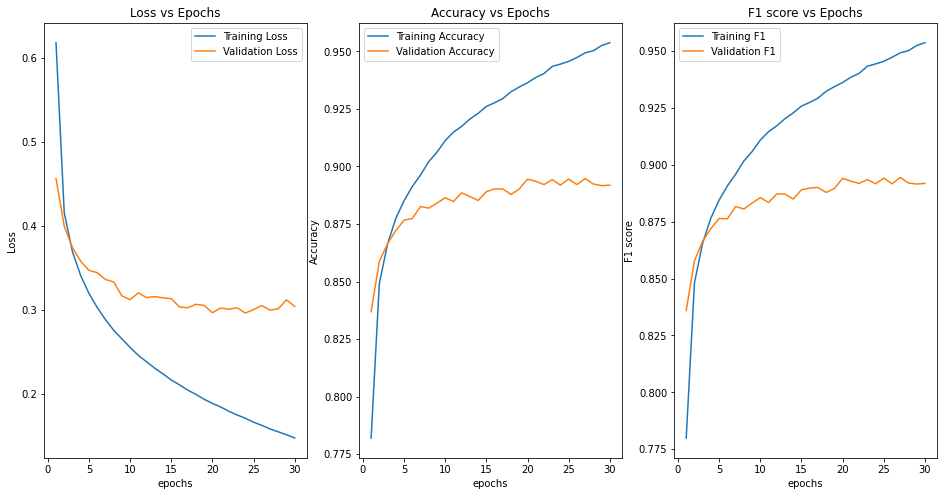

Loading model at epoch 27 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3300 Accuracy: 0.8873 F1_score: 0.8872
Result on unlabelled test set: Loss: 11.1416 Accuracy: 0.0000 F1_score: 0.0000
Result on full test set      : Loss: 3.5718 Accuracy: 0.6211 F1_score: 0.5366


In [5]:
whole_flow(6, False)

## Baseline #2, use full Fashion-MNIST dataset to train

Getting train and validate dataloaders for mode 7: use full FasionMNIST data
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5558 Accuracy: 0.8124 F1_score: 0.8102
	Validation - Loss: 0.4086 Accuracy: 0.8555 F1_score: 0.8527
Epoch: 2
	Train      - Loss: 0.3671 Accuracy: 0.8706 F1_score: 0.8700
	Validation - Loss: 0.3559 Accuracy: 0.8740 F1_score: 0.8740
Epoch: 3
	Train      - Loss: 0.3244 Accuracy: 0.8855 F1_score: 0.8849
	Validation - Loss: 0.3282 Accuracy: 0.8872 F1_score: 0.8867
Epoch: 4
	Train      - Loss: 0.2966 Accuracy: 0.8951 F1_score: 0.8946
	Validation - Loss: 0.3116 Accuracy: 0.8910 F1_score: 0.8911
Epoch: 5
	Train      - Loss: 0.2767 Accuracy: 0.9032 F1_score: 0.9028
	Validation - Loss: 0.3085 Accuracy: 0.8963 F1_score: 0.8968
Epoch: 6
	Train      - Loss: 0.2609 Accuracy: 0.9102 F1_score: 0.9098
	Validation - Loss: 0.3000 Accuracy: 0.8928 F1_score: 0.8909
Epoch: 7
	Train      - Loss: 0.2473 Accuracy: 0.9144 F1_score: 0.9141
	Validation - Loss: 0.3026 Accuracy: 0.8948 F

<Figure size 432x288 with 0 Axes>

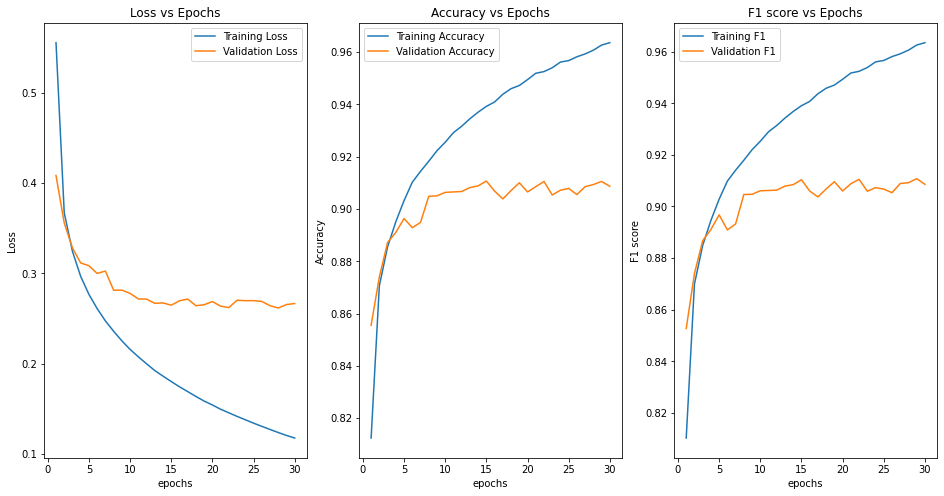

Loading model at epoch 29 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3539 Accuracy: 0.8766 F1_score: 0.8792
Result on unlabelled test set: Loss: 0.0977 Accuracy: 0.9697 F1_score: 0.9757
Result on full test set      : Loss: 0.2772 Accuracy: 0.9045 F1_score: 0.9038


In [6]:
whole_flow(7, False)

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

Getting train and validate dataloaders for mode 0: clustering: kmeans
Labeling unlabeled data...
Labeling accuracy: 0.8798333333333334
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5442 Accuracy: 0.8181 F1_score: 0.8153
	Validation - Loss: 0.4126 Accuracy: 0.8578 F1_score: 0.8551
Epoch: 2
	Train      - Loss: 0.3649 Accuracy: 0.8716 F1_score: 0.8707
	Validation - Loss: 0.3619 Accuracy: 0.8733 F1_score: 0.8726
Epoch: 3
	Train      - Loss: 0.3226 Accuracy: 0.8863 F1_score: 0.8856
	Validation - Loss: 0.3413 Accuracy: 0.8853 F1_score: 0.8838
Epoch: 4
	Train      - Loss: 0.2955 Accuracy: 0.8969 F1_score: 0.8963
	Validation - Loss: 0.3261 Accuracy: 0.8862 F1_score: 0.8847
Epoch: 5
	Train      - Loss: 0.2747 Accuracy: 0.9046 F1_score: 0.9043
	Validation - Loss: 0.3134 Accuracy: 0.8897 F1_score: 0.8894
Epoch: 6
	Train      - Loss: 0.2588 Accuracy: 0.9111 F1_score: 0.9107
	Validation - Loss: 0.3062 Accuracy: 0.8925 F1_score: 0.8917
Epoch: 7
	Train      - Loss: 0.2459 Accuracy: 0.9151 F1_s

<Figure size 432x288 with 0 Axes>

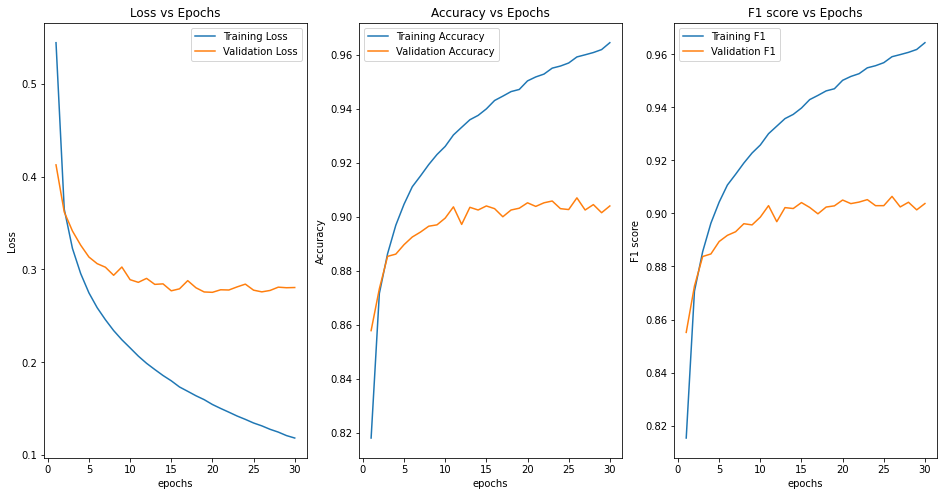

Loading model at epoch 26 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3435 Accuracy: 0.8823 F1_score: 0.8860
Result on unlabelled test set: Loss: 0.6673 Accuracy: 0.8807 F1_score: 0.8894
Result on full test set      : Loss: 0.4425 Accuracy: 0.8818 F1_score: 0.8821


In [7]:
whole_flow(0, False)

## Approach #2, use KMeans with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 1: clustering: kmeans with PCA
Labeling unlabeled data...
Labeling accuracy: 0.8809444444444444
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5357 Accuracy: 0.8199 F1_score: 0.8178
	Validation - Loss: 0.4052 Accuracy: 0.8568 F1_score: 0.8560
Epoch: 2
	Train      - Loss: 0.3568 Accuracy: 0.8759 F1_score: 0.8751
	Validation - Loss: 0.3623 Accuracy: 0.8715 F1_score: 0.8724
Epoch: 3
	Train      - Loss: 0.3160 Accuracy: 0.8898 F1_score: 0.8893
	Validation - Loss: 0.3325 Accuracy: 0.8853 F1_score: 0.8850
Epoch: 4
	Train      - Loss: 0.2899 Accuracy: 0.8989 F1_score: 0.8984
	Validation - Loss: 0.3126 Accuracy: 0.8902 F1_score: 0.8902
Epoch: 5
	Train      - Loss: 0.2699 Accuracy: 0.9070 F1_score: 0.9066
	Validation - Loss: 0.3073 Accuracy: 0.8912 F1_score: 0.8909
Epoch: 6
	Train      - Loss: 0.2548 Accuracy: 0.9121 F1_score: 0.9118
	Validation - Loss: 0.3007 Accuracy: 0.8935 F1_score: 0.8943
Epoch: 7
	Train      - Loss: 0.2415 Accuracy: 0.

<Figure size 432x288 with 0 Axes>

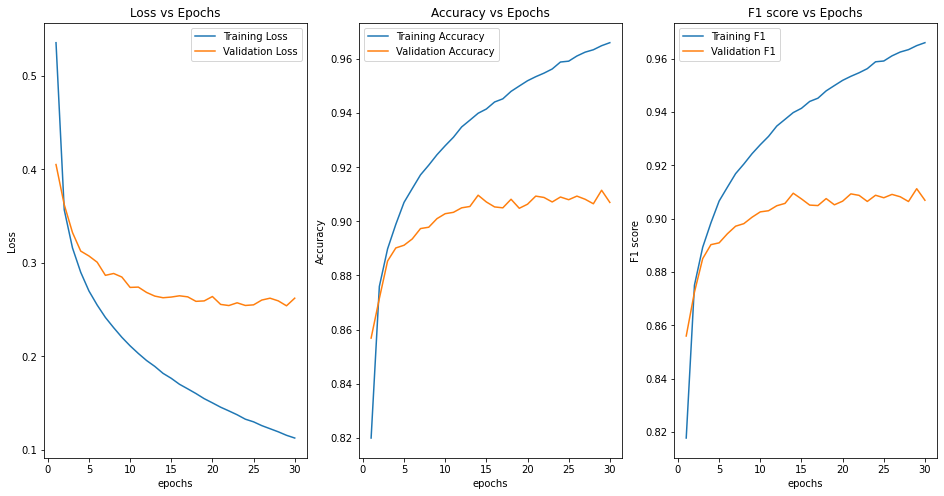

Loading model at epoch 29 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3390 Accuracy: 0.8804 F1_score: 0.8834
Result on unlabelled test set: Loss: 0.6259 Accuracy: 0.8853 F1_score: 0.8932
Result on full test set      : Loss: 0.4283 Accuracy: 0.8819 F1_score: 0.8821


In [8]:
whole_flow(1, False)

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

Getting train and validate dataloaders for mode 2: clustering: kmeans with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...
Epoch: 1 Loss: {'loss': 0.03425742100874583}
Epoch: 2 Loss: {'loss': 0.024974419085184732}
Epoch: 3 Loss: {'loss': 0.02269909619987011}
Epoch: 4 Loss: {'loss': 0.02188471697817246}
Epoch: 5 Loss: {'loss': 0.0213490866313378}
Epoch: 6 Loss: {'loss': 0.021030877032876014}
Epoch: 7 Loss: {'loss': 0.02078864043901364}
Epoch: 8 Loss: {'loss': 0.020635993178685506}
Epoch: 9 Loss: {'loss': 0.020481290885309377}
Epoch: 10 Loss: {'loss': 0.02041597151259581}
Labeling accuracy: 0.33544444444444443
Start Training... Net
Epoch: 1
	Train      - Loss: 0.6968 Accuracy: 0.7429 F1_score: 0.7116
	Validation - Loss: 0.5792 Accuracy: 0.7770 F1_score: 0.7412
Epoch: 2
	Train      - Loss: 0.5281 Accuracy: 0.7931 F1_score: 0.7611
	Validation - Loss: 0.5301 Accuracy: 0.7902 F1_score: 0.7601
Epoch: 3
	Train      - Loss: 0.4860 Accuracy: 0.8080 F1_score: 0.7769
	Validation -

<Figure size 432x288 with 0 Axes>

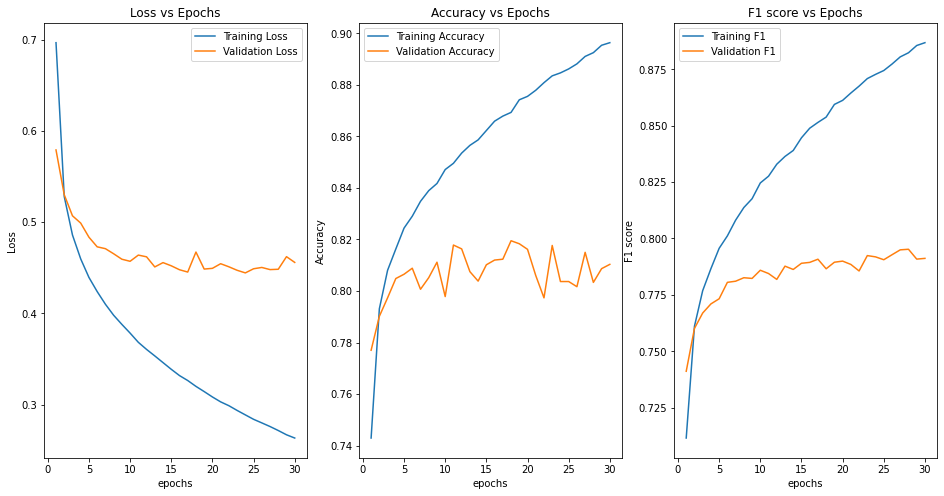

Loading model at epoch 28 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3534 Accuracy: 0.8774 F1_score: 0.8796
Result on unlabelled test set: Loss: 5.3349 Accuracy: 0.3717 F1_score: 0.2625
Result on full test set      : Loss: 1.8431 Accuracy: 0.7257 F1_score: 0.6916


In [9]:
whole_flow(2, False)

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

Getting train and validate dataloaders for mode 3: clustering: Gaussian Mixture
Labeling unlabeled data...
Labeling accuracy: 0.8389444444444445
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5432 Accuracy: 0.8194 F1_score: 0.8174
	Validation - Loss: 0.4053 Accuracy: 0.8548 F1_score: 0.8546
Epoch: 2
	Train      - Loss: 0.3577 Accuracy: 0.8748 F1_score: 0.8740
	Validation - Loss: 0.3614 Accuracy: 0.8717 F1_score: 0.8713
Epoch: 3
	Train      - Loss: 0.3154 Accuracy: 0.8898 F1_score: 0.8893
	Validation - Loss: 0.3340 Accuracy: 0.8775 F1_score: 0.8774
Epoch: 4
	Train      - Loss: 0.2881 Accuracy: 0.8995 F1_score: 0.8990
	Validation - Loss: 0.3189 Accuracy: 0.8848 F1_score: 0.8850
Epoch: 5
	Train      - Loss: 0.2681 Accuracy: 0.9080 F1_score: 0.9076
	Validation - Loss: 0.3063 Accuracy: 0.8908 F1_score: 0.8910
Epoch: 6
	Train      - Loss: 0.2518 Accuracy: 0.9121 F1_score: 0.9117
	Validation - Loss: 0.3008 Accuracy: 0.8955 F1_score: 0.8952
Epoch: 7
	Train      - Loss: 0.2392 Accuracy: 0

<Figure size 432x288 with 0 Axes>

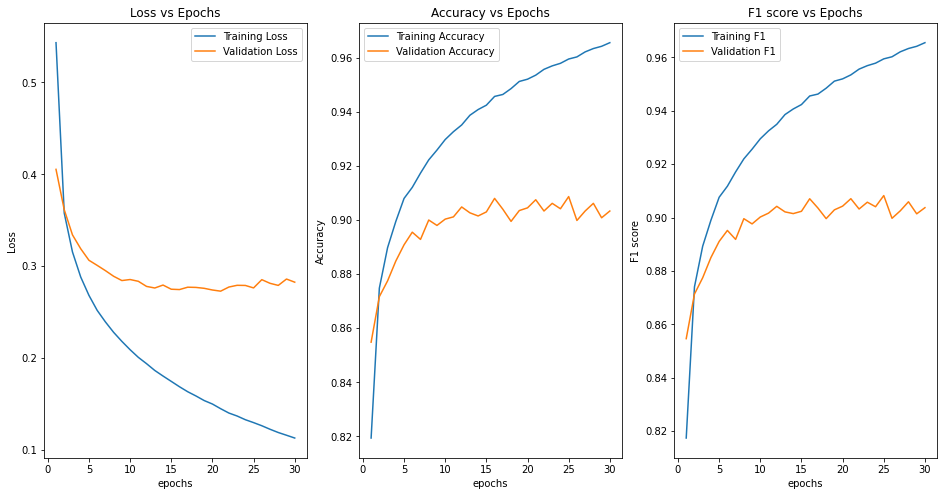

Loading model at epoch 25 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3341 Accuracy: 0.8829 F1_score: 0.8861
Result on unlabelled test set: Loss: 1.2044 Accuracy: 0.8307 F1_score: 0.8356
Result on full test set      : Loss: 0.5937 Accuracy: 0.8672 F1_score: 0.8668


In [10]:
whole_flow(3, False)

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 4: clustering: Gaussian Mixture with PCA
Labeling unlabeled data...
Labeling accuracy: 0.7592777777777778
Start Training... Net
Epoch: 1
	Train      - Loss: 0.5505 Accuracy: 0.8154 F1_score: 0.8137
	Validation - Loss: 0.3912 Accuracy: 0.8623 F1_score: 0.8628
Epoch: 2
	Train      - Loss: 0.3601 Accuracy: 0.8731 F1_score: 0.8723
	Validation - Loss: 0.3456 Accuracy: 0.8745 F1_score: 0.8735
Epoch: 3
	Train      - Loss: 0.3191 Accuracy: 0.8882 F1_score: 0.8876
	Validation - Loss: 0.3197 Accuracy: 0.8847 F1_score: 0.8839
Epoch: 4
	Train      - Loss: 0.2938 Accuracy: 0.8984 F1_score: 0.8978
	Validation - Loss: 0.3078 Accuracy: 0.8903 F1_score: 0.8903
Epoch: 5
	Train      - Loss: 0.2753 Accuracy: 0.9053 F1_score: 0.9049
	Validation - Loss: 0.2982 Accuracy: 0.8930 F1_score: 0.8922
Epoch: 6
	Train      - Loss: 0.2608 Accuracy: 0.9102 F1_score: 0.9098
	Validation - Loss: 0.2885 Accuracy: 0.8952 F1_score: 0.8954
Epoch: 7
	Train      - Loss: 0.2479 Ac

<Figure size 432x288 with 0 Axes>

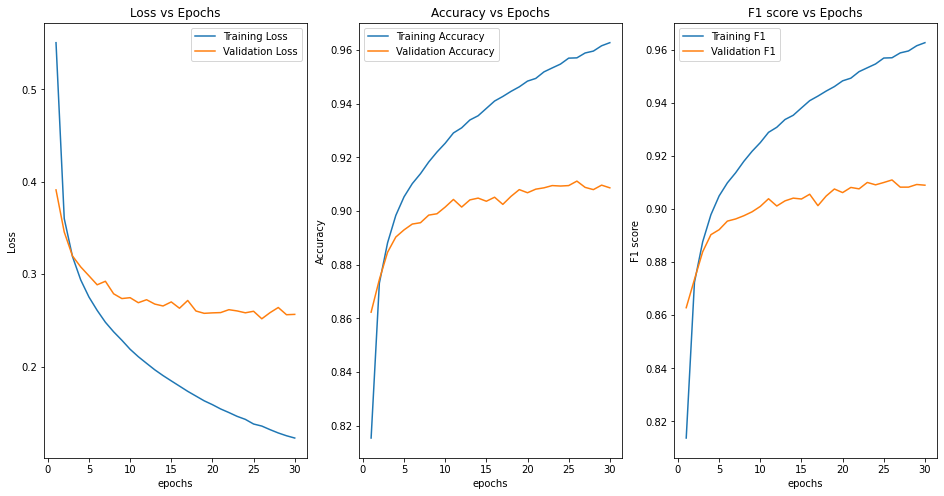

Loading model at epoch 26 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3399 Accuracy: 0.8837 F1_score: 0.8882
Result on unlabelled test set: Loss: 2.0531 Accuracy: 0.7600 F1_score: 0.7586
Result on full test set      : Loss: 0.8510 Accuracy: 0.8466 F1_score: 0.8448


In [11]:
whole_flow(4, False)

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

Getting train and validate dataloaders for mode 5: clustering: Gaussian Mixture with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...
Epoch: 1 Loss: {'loss': 0.03754856948653857}
Epoch: 2 Loss: {'loss': 0.02552626453737418}
Epoch: 3 Loss: {'loss': 0.02359724606970946}
Epoch: 4 Loss: {'loss': 0.022500311238567033}
Epoch: 5 Loss: {'loss': 0.02159243076493343}
Epoch: 6 Loss: {'loss': 0.021125903381903965}
Epoch: 7 Loss: {'loss': 0.020873484910527866}
Epoch: 8 Loss: {'loss': 0.020700990892450016}
Epoch: 9 Loss: {'loss': 0.020585300792753697}
Epoch: 10 Loss: {'loss': 0.02048394166827202}
Labeling accuracy: 0.33994444444444444
Start Training... Net
Epoch: 1
	Train      - Loss: 0.8412 Accuracy: 0.6417 F1_score: 0.6349
	Validation - Loss: 0.7153 Accuracy: 0.6675 F1_score: 0.6613
Epoch: 2
	Train      - Loss: 0.6766 Accuracy: 0.6937 F1_score: 0.6902
	Validation - Loss: 0.6755 Accuracy: 0.6810 F1_score: 0.6783
Epoch: 3
	Train      - Loss: 0.6333 Accuracy: 0.7145 F1_score: 0.7118
	

<Figure size 432x288 with 0 Axes>

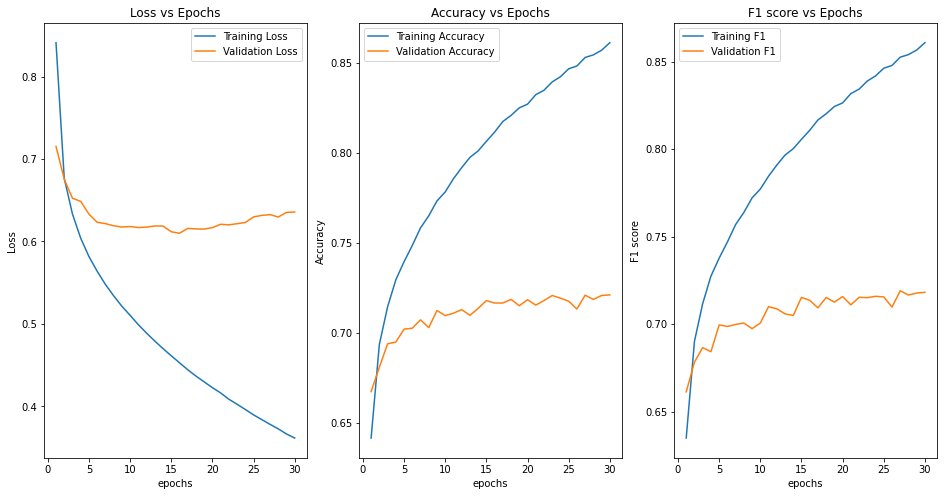

Loading model at epoch 27 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.3491 Accuracy: 0.8773 F1_score: 0.8794
Result on unlabelled test set: Loss: 1.2589 Accuracy: 0.3500 F1_score: 0.3498
Result on full test set      : Loss: 0.6221 Accuracy: 0.7191 F1_score: 0.7170


In [12]:
whole_flow(5, False)

<Figure size 432x288 with 0 Axes>

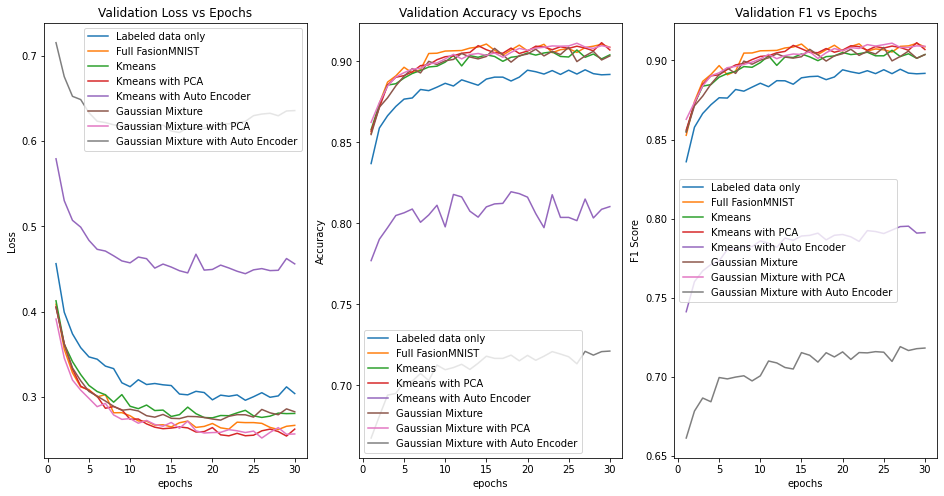

In [13]:
report_summary(mode_metrics, mode_description_short)

## Conclusion

- overview of all the methods
- eight methods are compared
- final method for best accuracy